# PIK3CA: Effects of Hotspot Mutation on AKT3

In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

### Import CPTAC

In [3]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [4]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

In [5]:
protein = 'AKT3'
gene = 'PIK3CA'

## Extract the data for hotspot mutations only 

In [6]:
#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

In [7]:
p10_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
#print(p10_mutations)
p10_mutations['Within_Hotspot'] = False
p10_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
p10_mutations.loc[p10_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p10_mutations = p10_mutations.loc[p10_mutations['Patient_Type'] == 'Tumor'].dropna(axis=0)
print(len(p10_mutations.loc[(p10_mutations['Within_Hotspot'] == True)]))

19


## Hotspot mutation vs non-hotspot mutation

In [8]:
in_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
out_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == False]
ttest = scipy.stats.ttest_ind(in_hotspot[protein], out_hotspot[protein])
print(ttest)

Ttest_indResult(statistic=-1.659697810970778, pvalue=0.10377857023888483)


## Hotspot mutation vs other mutations and wildtype

In [9]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] != True]
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-1.9711745325497052, pvalue=0.051524214301202485)


## All mutations vs wildtype

In [10]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] != 'Wildtype']
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-1.4543038446883627, pvalue=0.14905741255693958)


## Hotspot mutation v wildtype

In [11]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-1.9762353693819046, pvalue=0.052127356256827656)


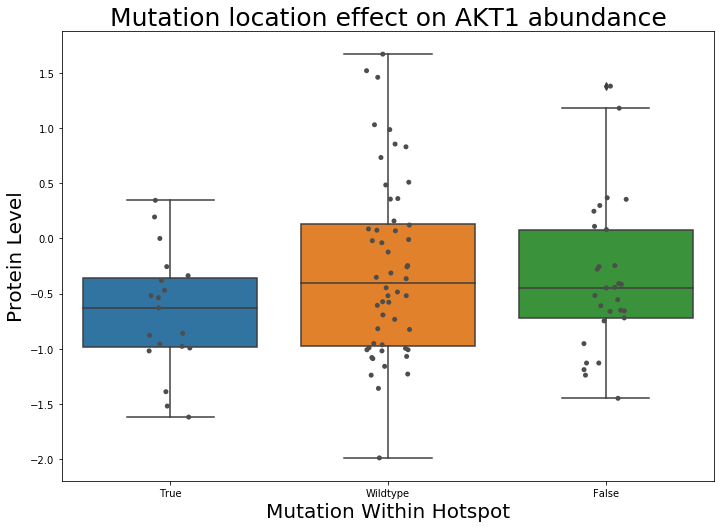

In [12]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p10_mutations, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = p10_mutations, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on AKT1 abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

# Phosphoproteomic Abundance

In [13]:
phos_mutations = CPTAC.compare_mutations(phos, protein, gene)
phos_mutations['Within_Hotspot'] = False
phos_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True

phos_mutations.loc[phos_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
print(phos_mutations)


phos_mutations = phos_mutations.loc[phos_mutations['Patient_Type'] == 'Tumor']
#phos_mutations = phos_mutations.dropna(axis = 0)
#print(phos_mutations)
phos_sites = list(phos_mutations)
phos_sites = phos_sites[:(len(phos_sites) - 3)]

      AKT3-S34  AKT3-T122  AKT3-T445  AKT3-T447           Mutation  \
S001       NaN        NaN        NaN   -0.49900  Missense_Mutation   
S002    -1.160        NaN        NaN   -0.73100           Wildtype   
S003       NaN        NaN        NaN    0.00275  Missense_Mutation   
S004       NaN        NaN        NaN   -0.80700           Wildtype   
S005       NaN        NaN        NaN   -1.56000           Wildtype   
S006       NaN        NaN        NaN   -0.78600           Wildtype   
S007    -1.130        NaN        NaN   -0.87200           Wildtype   
S008       NaN        NaN        NaN   -0.41800           Wildtype   
S009       NaN        NaN        NaN   -0.35000  Missense_Mutation   
S010       NaN        NaN        NaN   -0.44100  Missense_Mutation   
S011       NaN        NaN        NaN   -1.45000           Wildtype   
S012       NaN        NaN        NaN   -0.49500  Missense_Mutation   
S013       NaN        NaN        NaN   -0.93400           Wildtype   
S014       NaN      

## Hotspot mutation vs non-hotspot mutation

In [14]:
p_values = []
site_names = []

for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == False]
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    print(ttest)
    p_values.append(ttest[1])
    site_names.append(site) 
    
    
#areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
#pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
#significant_sites = np.array(site_names)[np.array(areSignificant)]
#significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

#significant_vals = dict(zip(significant_sites, significant_pvalues))


#print(significant_sites)
#print(significant_pvalues)
#print(significant_vals)

Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=-0.8031587928710945, pvalue=0.42601361742943733)


## Hotspot mutation vs other mutations and wildtype

In [15]:
p_values = []
site_names = []

for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] != True]
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    print(site, " ", ttest)
    p_values.append(ttest[1])
    site_names.append(site) 
    
    
#areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
#pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
#significant_sites = np.array(site_names)[np.array(areSignificant)]
#significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

#significant_vals = dict(zip(significant_sites, significant_pvalues))


#print(significant_sites)
#print(significant_pvalues)
#print(significant_vals)

AKT3-S34   Ttest_indResult(statistic=nan, pvalue=nan)
AKT3-T122   Ttest_indResult(statistic=nan, pvalue=nan)
AKT3-T445   Ttest_indResult(statistic=nan, pvalue=nan)
AKT3-T447   Ttest_indResult(statistic=-0.4612076371619941, pvalue=0.645671639481149)


## All mutations vs wildtype

In [16]:
p_values = []
site_names = []

for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] != 'Wildtype']
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == 'Wildtype']
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    print(site, " ", ttest)
    p_values.append(ttest[1])
    site_names.append(site) 
    
    
#areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
#pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
#significant_sites = np.array(site_names)[np.array(areSignificant)]
#significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

#significant_vals = dict(zip(significant_sites, significant_pvalues))


#print(significant_sites)
#print(significant_pvalues)
#print(significant_vals)

AKT3-S34   Ttest_indResult(statistic=1.2817298280818046, pvalue=0.21939586545789172)
AKT3-T122   Ttest_indResult(statistic=nan, pvalue=nan)
AKT3-T445   Ttest_indResult(statistic=0.7053141198318562, pvalue=0.5195207865743843)
AKT3-T447   Ttest_indResult(statistic=0.5082815540902769, pvalue=0.6123981586819851)


## Hotspot mutation v wildtype

In [19]:
p_values = []
site_names = []

for site in phos_sites:
    mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = mutated[site].tolist()
    mutated_list = [x for x in mutated_list if str(x) != 'nan']
    #print(mutated_list)
    wt = phos_mutations.loc[phos_mutations['Within_Hotspot'] == False]
    wt_list = wt[site].tolist()
    wt_list = [x for x in wt_list if str(x) != 'nan']
    
    ttest = scipy.stats.ttest_ind(mutated_list, wt_list)
    print(site, " ", ttest)
    p_values.append(ttest[1])
    site_names.append(site) 
    
    
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values)[0]
pvalues = statsmodels.stats.multitest.fdrcorrection(p_values)[1]
significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

AKT3-S34   Ttest_indResult(statistic=nan, pvalue=nan)
AKT3-T122   Ttest_indResult(statistic=nan, pvalue=nan)
AKT3-T445   Ttest_indResult(statistic=nan, pvalue=nan)
AKT3-T447   Ttest_indResult(statistic=-0.8031587928710945, pvalue=0.42601361742943733)
[]
[]
{}


/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha


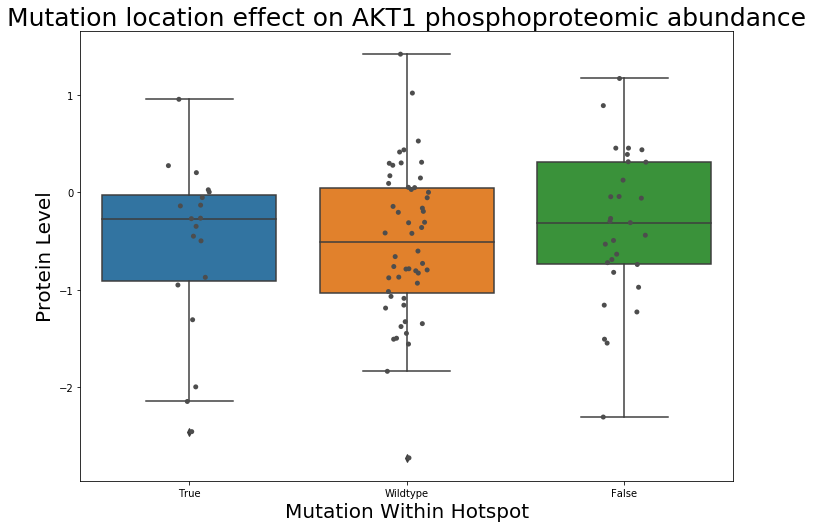

In [18]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = phos_mutations, x = 'Within_Hotspot', y = 'AKT3-T447', ax = ax)
boxplt = sns.stripplot(data = phos_mutations, x = 'Within_Hotspot', y = 'AKT3-T447', jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on AKT1 phosphoproteomic abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()